In [1]:
import pandas as pd
import math
from biom import Table, load_table
from biom.util import biom_open
from scipy.stats import chisquare
from statistics import stdev
from scipy.stats import f_oneway

import qiime2 as q2
from qiime2.plugins.taxa.actions import collapse 

## Import metadata

In [2]:
#From qiita
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/metadata/raw/"

qiita_doty=pd.read_csv(root_dir + '11712_20200406-134620.txt',sep='\t',index_col='sample_name',na_values='not applicable')
qiita_stillwell= pd.read_csv(root_dir + '11713_20190821-085347.txt',sep='\t',index_col='sample_name')
qiita_rhee= pd.read_csv(root_dir + '10918_20191014-140039.txt',sep='\t',index_col='sample_name')

qiita_doty=qiita_doty.fillna("not applicable")

#Get Stillwell antibiotics from clinical data
stillwell_clinical_abx = pd.read_csv(root_dir + "stillwell_abx_clinical.txt", sep='\t', index_col=0).dropna()
stillwell_abx_dict = {name:row["abx_at_birth"] for name,row in stillwell_clinical_abx.iterrows()}

def abx_f(row):
    host_id = row.host_subject_id
    try:
        return(stillwell_abx_dict[host_id])
    except KeyError:
        return("missing: not collected")
qiita_stillwell["metadata_abx"] = qiita_stillwell.apply(axis=1, func=abx_f)

####Fix age#####
#Convert Rhee from years to days
def convert_years_to_days(x):
    try:
        return(float(x)*365)
    except ValueError:
        return(x)
qiita_rhee["age"] = qiita_rhee.age.apply(convert_years_to_days)
qiita_rhee["age_units"] = "days"
#Rename baby_delivery to delivery_mode
qiita_rhee = qiita_rhee.rename(columns={"baby_delivery":"delivery_mode"})
qiita_rhee["abx_any_source"] = 0

#Doty day of birth is coded as 1, Stillwell day of birth is coded as 0.
##Change Doty day of birth to be 0.
def fix_doty_age(x):
    try:
        return(int(x)-1)
    except ValueError:
        return(x)
def fix_doty_abx_day(x):
    '''Subtract 1 from day, but not when abx==0 becuase that means never.'''
    if x=="0":
        return("0")
    try:
        return(int(x)-1)
    except ValueError:
        return(x)
qiita_doty["age"] = qiita_doty.age.apply(fix_doty_age)
qiita_doty["abx"] = qiita_doty.abx.apply(fix_doty_abx_day)
qiita_doty["dol_fullfeed_dc"] = qiita_doty.dol_fullfeed_dc.apply(fix_doty_age)

#Change oral to Oral in stillwell
qiita_stillwell = qiita_stillwell.replace({"oral":"Oral"})

Drop blank and get only stool, oral, skin

In [3]:
##########
###Doty###
##########

doty_total=qiita_doty.shape[0]
doty_samples_discard = []
doty_bm_samples = []
doty_count = {"age":0,"abx":0,"blank":0,"bm":0}
for name,row in qiita_doty.iterrows():
    if row.sample_type in ["Donor Breast Milk","Mother Breast Milk"]:
        doty_count["bm"] +=1
        doty_samples_discard.append(name)
        doty_bm_samples.append(name)
        continue
    blank_names=["blank","control","std","ctrl"]
    if any([x in name.lower() for x in blank_names]):
        doty_count["blank"] +=1
        doty_samples_discard.append(name)
        continue
qiita_doty = qiita_doty.query('index not in @doty_samples_discard')

print("Doty:")
print("{}/{} samples excluded from Doty.".format(sum(doty_count.values()),doty_total))
print("\t {} for being a breastmilk sample.".format(doty_count["bm"]))
print("\t {} for being a blank.".format(doty_count["blank"]))
print()
###############
###Stillwell###
###############
stillwell_total=qiita_stillwell.shape[0]
stillwell_samples_discard = []
stillwell_count = {"age":0,"abx":0,"blank":0, "sample_type":0}
for name,row in qiita_stillwell.iterrows():
    decontam_blanks = ["blank","control","std","ctrl"]
    blank_names=["blank","control","std","ctrl"]
    if any([x in name.lower() for x in blank_names]):
        stillwell_count["blank"] +=1
        stillwell_samples_discard.append(name)
        continue
    if row.sample_type == "Colostrum":
        stillwell_count["sample_type"] +=1
        stillwell_samples_discard.append(name)
        continue  
qiita_stillwell = qiita_stillwell.query('index not in @stillwell_samples_discard')
print("Stillwell:")
print("{}/{} samples excluded from Stillwell.".format(sum(stillwell_count.values()),stillwell_total))
print("\t {} for being Colostrum.".format(stillwell_count["sample_type"]))
print("\t {} for being a blank.".format(stillwell_count["blank"]))
print()
print()

#Summarize for Consort diagram
temp_md = pd.concat([qiita_doty,qiita_stillwell], sort=True)
print("Total samples: %s" % temp_md.shape[0])
temp_md.sample_type.value_counts()
                    

Doty:
402/1733 samples excluded from Doty.
	 58 for being a breastmilk sample.
	 344 for being a blank.

Stillwell:
179/647 samples excluded from Stillwell.
	 6 for being Colostrum.
	 173 for being a blank.


Total samples: 1799


Oral     602
Skin     599
Stool    598
Name: sample_type, dtype: int64

In [4]:
temp_md = pd.concat([qiita_doty.loc[:,["sample_type","host_subject_id","qiita_study_id"]],qiita_stillwell.loc[:,["sample_type","host_subject_id","qiita_study_id"]]], sort=True)
print("Total samples: %s" % temp_md.shape[0])
print("Total infants: %s" % len(set(temp_md.host_subject_id)))
print("LP infants: {}".format(len(set(temp_md.query('qiita_study_id==11712').host_subject_id))))
print("VLBW infants: {}".format(len(set(temp_md.query('qiita_study_id==11713').host_subject_id))))

Total samples: 1799
Total infants: 85
LP infants: 60
VLBW infants: 25


Filter for invalid metadata

In [5]:
##########
###Doty###
##########

doty_total=qiita_doty.shape[0]
doty_samples_discard = []
doty_bm_samples = []
for name,row in qiita_doty.iterrows():
    try:
        #Chck for int age
        temp = int(row.age)
    except ValueError:
        doty_count["age"] +=1
        doty_samples_discard.append(name)
    try:
        #Check for int abx start day
        temp= int(row.abx)
    except ValueError:
        doty_count["abx"] +=1
        doty_samples_discard.append(name)
qiita_doty_bm = qiita_doty.query('index in @doty_bm_samples')
qiita_doty = qiita_doty.query('index not in @doty_samples_discard')

print("Doty:")
print("\t {} for invalid age.".format(doty_count["age"]))
print("\t {} for invalid abx.".format(doty_count["abx"]))
print()
###############
###Stillwell###
###############
stillwell_total=qiita_stillwell.shape[0]
stillwell_samples_discard = []
stillwell_count = {"age":0,"abx":0,"blank":0, "sample_type":0}
for name,row in qiita_stillwell.iterrows():
    blank_names=["blank","control","std","ctrl"]
    if any([x in name.lower() for x in blank_names]):
        stillwell_count["blank"] +=1
        stillwell_samples_discard.append(name)
        continue
    if row.sample_type == "Colostrum":
        stillwell_count["sample_type"] +=1
        stillwell_samples_discard.append(name)
        continue
    try:
        #Chck for int age
        temp = int(row.age)
    except ValueError:
        print(name,row.age,row.delivery_mode)
        stillwell_count["age"] +=1
        stillwell_samples_discard.append(name)
    try:
        #Check for int abx start day
        temp= int(row.metadata_abx)
    except ValueError:
        stillwell_count["abx"] +=1
        stillwell_samples_discard.append(name)
    
qiita_stillwell = qiita_stillwell.query('index not in @stillwell_samples_discard')
print("Stillwell:")
print("\t {} for invalid age.".format(stillwell_count["age"]))
print("\t {} for invalid abx.".format(stillwell_count["abx"]))
print()
print()

#Summarize for Consort diagram
temp_md = pd.concat([qiita_doty.loc[:,["sample_type","host_subject_id","qiita_study_id"]],qiita_stillwell.loc[:,["sample_type","host_subject_id","qiita_study_id"]]], sort=True)
print("Total samples: %s" % temp_md.shape[0])
print("Total infants: %s" % len(set(temp_md.host_subject_id)))
print("Total LP infants: %s" % len(set(temp_md.query('qiita_study_id=="11712"').host_subject_id)))
print("Total VLBW infants: %s" % len(set(temp_md.query('qiita_study_id=="11713"').host_subject_id)))
temp_md.sample_type.value_counts()

Doty:
	 8 for invalid age.
	 3 for invalid abx.

Stillwell:
	 0 for invalid age.
	 0 for invalid abx.


Total samples: 1791
Total infants: 82
Total LP infants: 57
Total VLBW infants: 25


Oral     602
Skin     599
Stool    590
Name: sample_type, dtype: int64

Filter Rhee

In [6]:
##########
###Rhee###
##########
age_min=14
age_max=120
rhee_total=qiita_rhee.shape[0]
rhee_samples_discard = []
rhee_count = {"age":0,"abx":0,"blank":0,"delivery_mode":0,"outside_age_range":0}
for name,row in qiita_rhee.iterrows():
    blank_names=["blank","control","std","ctrl"]
    if any([x in name.lower() for x in blank_names]):
        rhee_count["blank"] +=1
        rhee_samples_discard.append(name)
        continue
    try:
        #Chck for int age
        temp = float(row.age)
    except ValueError:
        rhee_count["age"] +=1
        rhee_samples_discard.append(name)
        continue
    #if not row.delivery_mode=="vaginal":
        #rhee_count["delivery_mode"] +=1
        #rhee_samples_discard.append(name)
    if row.age < age_min or row.age > age_max:
        rhee_count["outside_age_range"] +=1
        rhee_samples_discard.append(name)
qiita_rhee = qiita_rhee.query('index not in @rhee_samples_discard')
print("Rhee:")
print("{}/{} samples excluded from Rhee.".format(sum(rhee_count.values()),rhee_total))
print("\t {} for being a blank.".format(rhee_count["blank"]))
print("\t {} for invalid age.".format(rhee_count["age"]))
print("\t {} for not being vaginal birth.".format(rhee_count["delivery_mode"]))
print("\t {} for being outside age range.".format(rhee_count["outside_age_range"]))
print()

Rhee:
243/343 samples excluded from Rhee.
	 32 for being a blank.
	 8 for invalid age.
	 0 for not being vaginal birth.
	 203 for being outside age range.



# Formatting  
Convert columns to ints

In [7]:
#Convert to ints
qiita_doty["age"] = qiita_doty["age"].apply(int)
qiita_doty["abx"] = qiita_doty["abx"].apply(int)
qiita_stillwell["age"] = qiita_stillwell["age"].apply(int)
qiita_stillwell["metadata_abx"] = qiita_stillwell["metadata_abx"].apply(int)

#Change oral to Oral in stillwell
qiita_stillwell = qiita_stillwell.replace({"oral":"Oral"})

#Change feces to Stool in Rhee
qiita_rhee["sample_type"] =  qiita_rhee["sample_type"].replace({"feces":"Stool"})

#Make study_delivery_mode
qiita_stillwell["study_delivery_mode"] = qiita_stillwell.apply(axis=1, func=lambda row:"VLBW-C-section" if row.delivery_mode=="c-section" else "VLBW-Vaginal")
qiita_doty["study_delivery_mode"] = qiita_doty.apply(axis=1, func=lambda row:"LP-C-section" if row.delivery_mode=="c-section" else "LP-Vaginal")
qiita_rhee["study_delivery_mode"] = qiita_rhee.apply(axis=1, func=lambda row:"Fullterm-C-section" if row.delivery_mode=="c-section" else "Fullterm-Vaginal")

# Antibiotics metadata

In [8]:
# column: metadata_abx
# Sample has been exposed to antibiotics in metadata on same day or previous day
# already exists for Stillwell

##########
###Doty###
##########
#Make dict of first day of abx
stody_abx_dict=qiita_doty.groupby("host_subject_id").agg({"abx":"first"}).to_dict()["abx"]
def add_metadata_abx(row):
    host_id= row.host_subject_id
    day=row.age
    abx_dict_value = stody_abx_dict[host_id]
    if abx_dict_value == 0:
        return(0)
    elif abx_dict_value > day:
        return(0)
    elif abx_dict_value <= day:
        return(1)
    raise ValueError("Problem with {}".format(row))
#Add metdata_abx column
qiita_doty["metadata_abx"] = qiita_doty.apply(axis=1, func=add_metadata_abx)


# Antibiotics detected in metabolomics
# - column: metabolomics_abx
# - On a per sample basis, only abx+ if detected in THAT sample

ms2_abx_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/metadata/antibiotics_ms2/"

#Doty
stool = pd.read_csv(ms2_abx_dir + "stool_abx_simple.txt", sep='\t', index_col=0)
stool_data = stool.apply( lambda x: any(x), axis=1)
stool_df = pd.DataFrame(index=stool_data.index, data={"metabolomics_abx":stool_data})

oral = pd.read_csv(ms2_abx_dir + "oral_abx_simple.txt", sep='\t', index_col=0)
oral_data = oral.apply( lambda x: any(x), axis=1)
oral_df = pd.DataFrame(index=oral_data.index, data={"metabolomics_abx":oral_data})

skin = pd.read_csv(ms2_abx_dir + "skin_abx_simple.txt", sep='\t', index_col=0)
skin_data = skin.apply( lambda x: any(x), axis=1)
skin_df = pd.DataFrame(index=skin_data.index, data={"metabolomics_abx":skin_data})

doty_abx_met_df = stool_df.append(oral_df).append(skin_df)
doty_abx_met_df["metabolomics_abx"] = doty_abx_met_df["metabolomics_abx"] > 0
doty_abx_met_df["metabolomics_abx"] = [1 if x else 0 for x in doty_abx_met_df["metabolomics_abx"]]

#Stillwell
lvbw_metadata = pd.read_csv(ms2_abx_dir + "stillwell_abx_simple.tsv", sep='\t', header=None, index_col=0)
lvbw_metadata.columns=["metabolomics_abx"]

lvbw_metadata["metabolomics_abx"] = lvbw_metadata["metabolomics_abx"] > 0
lvbw_metadata["metabolomics_abx"] = [1 if x else 0 for x in lvbw_metadata["metabolomics_abx"]]

#Add metabolomics abx by sample
qiita_doty = qiita_doty.merge(doty_abx_met_df.loc[:,"metabolomics_abx"], right_index=True, left_index=True, how="left")
qiita_doty["metabolomics_abx"] = qiita_doty["metabolomics_abx"].fillna(0)
qiita_stillwell = qiita_stillwell.merge(lvbw_metadata.loc[:,"metabolomics_abx"], right_index=True, left_index=True, how="left")
qiita_stillwell["metabolomics_abx"] = qiita_stillwell["metabolomics_abx"].fillna(0)

#MERGE METADATA
merged_md = pd.concat([qiita_doty,qiita_stillwell, qiita_rhee],axis=0, join="outer").fillna("missing: not collected")


# Make final abx column
# column: abx_any_source_ 
# abx were indicated in metadata on same or previous day  
# OR  
# abx were detected in that specific sample
def any_mom_abx(x):
    if x.qiita_study_id==11713:
        return(1)
    abx_cols=["maternal_amox","maternal_amp","maternal_ancef","maternal_azithro",
             "maternal_chorio","maternal_clinda","maternal_gent","maternal_pcn"]
    for abx in abx_cols:
        try:
            val= int(x[abx])
            if val > 0:
                return(1)
        except:
            continue
    return(0)
merged_md["maternal_any_abx"] = merged_md.apply(axis=1, func=any_mom_abx)



def any_abx(x):
    #If any antibiotics from any metadata or metabolomics source is True, return True
    
    abx_cols = ["metadata_abx","metabolomics_abx"]
    for col in abx_cols:
        if x[col] == "not provided":
            abx_cols.remove(col)
    if abx_cols==[]:
        return("not_provided")
    return( int(any([x[y]==1 for y in abx_cols])))

merged_md["abx_any_source"] = merged_md.apply(axis=1, func=any_abx)


def make_maternal_abx_012(x):
    '''0: no abx
        1:abx+
        2:abx-/mabx+
    '''
    if not x.metadata_abx:
        if x.maternal_any_abx:
            return(2)
        else:
            return(0)
    else:
        return(1)
    
merged_md["abx012"] = merged_md.apply(axis=1, func=make_maternal_abx_012)

#View antibiotic exposure totals
merged_md.groupby("qiita_study_id").maternal_any_abx.value_counts()

qiita_study_id  maternal_any_abx
10918           0                   100
11712           1                   982
                0                   341
11713           1                   468
Name: maternal_any_abx, dtype: int64

# Add feeding metadata

In [9]:
def day_of_first_any_feed(row):
    '''Gives day or first any type of feed'''
    null_values = ["not applicable", "not_collected","missing: not collected"]
    if row.qiita_study_id == 11712:
        first_formula =  row.hr_1stfeed
        first_fullfeed = row.dol_fullfeed_dc
        if first_formula in null_values and first_fullfeed in null_values:
            return("not_collected")
        elif first_formula in null_values and first_fullfeed not in null_values:
            first_feed = int(first_fullfeed)
        elif first_formula not in null_values and first_fullfeed in null_values:
            first_feed = math.ceil(int(first_formula)/24)
        elif first_formula not in null_values and first_fullfeed not in null_values:
            first_feed = min(math.ceil(int(first_formula)/24),int(first_fullfeed))
        else:
            raise ValueError()
        return(first_feed)
    elif row.qiita_study_id == 11713:
        return(row.dol_first_feeding)
    else:
        return("not applicable")

def days_to_any_feed(row):
    null_values = ["not applicable", "not_collected","missing: not collected"]
    if row.qiita_study_id == 11713:
        return(int(row.age) - int(row.dol_first_feeding))
    else:
        if row.dol_fullfeed_dc in null_values:
            return("not_collected")
        else:
            return(int(row.age) - int(row.day_of_first_any_feed)  )
        
def days_to_bm_f(row):
    null_values = ["not applicable", "not_collected","missing: not collected"]
    if row.dol_fullfeed_dc in null_values:
        return("not_collected")
    else:
        return((row.age - int(row.dol_fullfeed_dc) ))

def fed_yet_f(row):
    null_values = ["not applicable", "not_collected","missing: not collected"]
    if row.day_of_first_any_feed in null_values:
        return("not_collected")
    else:
        return(int( (int(row.day_of_first_any_feed) - row.age ) <= 0) )
        
def bm_yet_f(row):
    null_values = ["not applicable", "not_collected","missing: not collected"]
    if row.dol_fullfeed_dc in null_values:
        return("not_collected")
    else:
        return(int( (int(row.dol_fullfeed_dc) - row.age ) <= 0) )
    


merged_md["day_of_first_any_feed"] = merged_md.apply(day_of_first_any_feed, axis=1)
merged_md["days_to_any_feed"] = merged_md.apply(days_to_any_feed, axis=1)
merged_md["days_to_bm"] = merged_md.apply(days_to_bm_f, axis=1)

merged_md["any_fed_yet"] = merged_md.apply(fed_yet_f, axis=1)
merged_md["bm_yet"] = merged_md.apply(bm_yet_f, axis=1)




Save Rhee and breastmilk metadata

In [10]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"

rhee_md = merged_md.query('qiita_study_id==10918')
rhee_md.to_csv(root_dir + "metadata/20201106_rhee_filtered_metadata.tsv",sep='\t')

#Save breastmilk samples
qiita_doty_bm.to_csv(root_dir + "metadata/20200604_doty_bm_metadata.tsv", sep='\t')

# Final filtering and get counts for demographics table
- Need to factor in which samples actually exist
- Filter out samples outside age range

In [11]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"

#Import 16S
stillwell_bt = load_table(root_dir + "raw_data/56431_reference-hit.biom")
doty_bt = load_table(root_dir + "raw_data/56491_reference-hit.biom")
bac_bt = doty_bt.merge(stillwell_bt)

#Import metabolomics

met_doty_bt = load_table(root_dir + "raw_data/70260_doty_all_biom_normalized.biom")
met_swell_bt = load_table(root_dir + "raw_data/70373_stillwell_biom_normalized.biom")
met_bt = met_doty_bt.merge(met_swell_bt)

md= merged_md.query('qiita_study_id in [11712,11713]')

Filter metadata and biom tables

In [12]:
#Filter samples with no 16S or metabolomic data
md_samples = set( md.index )
bac_samples = set(bac_bt.ids())
met_samples = set(met_bt.ids())

bac_samples_keep = md_samples & bac_samples
met_samples_keep = md_samples & met_samples

#Keep only samples in metadata
bac_bt_filt = bac_bt.filter(bac_samples_keep, inplace=False)
met_bt_filt = met_bt.filter(met_samples_keep, inplace=False)
bac_md = md.query('index in @bac_samples_keep')
met_md = md.query('index in @met_samples_keep')


#Remove mitochondria and chloroplast sOTUs
tax_qza =  q2.Artifact.load(root_dir + "intermediate_data/stody_seq_classification.qza")
tax_md_qza = q2.Metadata(pd.DataFrame(tax_qza.view(pd.Series)))
tax_df = tax_qza.view(pd.DataFrame)
mito_taxa = [seq for seq,row in tax_df.iterrows() if "mitochondria" in row.Taxon or "Chloroplast" in row.Taxon]
bac_bt_filt = bac_bt_filt.filter(mito_taxa, invert=True, inplace=False, axis="observation")

#Print
n_bac_no_data = len(md_samples - bac_samples_keep)
n_met_no_data = len(md_samples - met_samples_keep)
print("{} 16S samples dropped for no data".format(n_bac_no_data))
print("{} Metabolomics samples dropped for no data".format(n_met_no_data))
print()
print("16S")
print("{} Infants total".format(len(set(bac_md.host_subject_id))))
print("{} Samples total".format(bac_md.shape[0]))
print(bac_md.sample_type.value_counts())
print()
print("Metabolomics")
print("{} Infants total".format(len(set(met_md.host_subject_id))))
print("{} Samples total".format(met_md.shape[0]))
print(met_md.sample_type.value_counts())
print()
print("{} samples matched for 16S and metabolomics".format(len(set(bac_md.index) & set(met_md.index))))
print()
###################################################################################
#Filter by age
bac_age_limit=7
met_age_limit=7

n_bac_outside_age = len(bac_md.query('age > @bac_age_limit').index)
n_met_outside_age = len(met_md.query('age > @met_age_limit').index)
bac_md = bac_md.query('age <= @bac_age_limit')
met_md = met_md.query('age <= @met_age_limit')
bac_bt_filt.filter( set(bac_md.index) )
met_bt_filt.filter( set(met_md.index) )

print("{} 16S samples dropped over {} days".format(n_bac_outside_age,bac_age_limit))
print("{} Metabolomics samples dropped over {} days".format(n_met_outside_age,met_age_limit))
print()
print("16S")
print("{} Infants total".format(len(set(bac_md.host_subject_id))))
print("{} Samples total".format(bac_md.shape[0]))
print(bac_md.sample_type.value_counts())
print()
print("Metabolomics")
print("{} Infants total".format(len(set(met_md.host_subject_id))))
print("{} Samples total".format(met_md.shape[0]))
print(met_md.sample_type.value_counts())
print()

print()
###################################################################################
#Drop VLBW-Vaginal and VLBW-C-section Abx-

bac_md["temp"] = md.apply(axis=1, func=lambda row: str(row.study_delivery_mode) + str(row.metadata_abx))
met_md["temp"] = md.apply(axis=1, func=lambda row: str(row.study_delivery_mode) + str(row.metadata_abx))
n_swell_drop_bac_vv = len(bac_md.query('temp  in ["VLBW-Vaginal1.0"]').index)
n_swell_drop_met_vv = len(met_md.query('temp  in ["VLBW-Vaginal1.0"]').index)
n_swell_drop_bac_vab = len(bac_md.query('temp  in ["VLBW-C-section0.0"]').index)
n_swell_drop_met_vab = len(met_md.query('temp  in ["VLBW-C-section0.0"]').index)
bac_md = bac_md.query('temp not in ["VLBW-C-section0.0","VLBW-Vaginal1.0"]')
met_md = met_md.query('temp not in ["VLBW-C-section0.0","VLBW-Vaginal1.0"]')
bac_bt_filt.filter( set(bac_md.index) )
met_bt_filt.filter( set(met_md.index) )
#Drop temp col
bac_md = bac_md.drop(columns=["temp"])
met_md = met_md.drop(columns=["temp"])

print("{} 16S samples dropped VLBW-Vaginal".format(n_swell_drop_bac_vv))
print("{} 16S samples dropped VLBW-Csection Abx-".format(n_swell_drop_bac_vab))
print("{} Metabolomics samples dropped VLBW-Vaginal".format(n_swell_drop_met_vv))
print("{} Metabolomics samples dropped VLBW-Csection Abx-".format(n_swell_drop_met_vab))

print()
print("16S")
print("{} Infants total".format(len(set(bac_md.host_subject_id))))
print("{} Samples total".format(bac_md.shape[0]))
print(bac_md.sample_type.value_counts())
print()
print("Metabolomics")
print("{} Infants total".format(len(set(met_md.host_subject_id))))
print("{} LP-V Infants total".format(len(set(met_md.query('study_delivery_mode=="LP-Vaginal"').host_subject_id))))
print("{} LP-C Infants total".format(len(set(met_md.query('study_delivery_mode=="LP-C-section"').host_subject_id))))
print("{} VLBW-C Infants total".format(len(set(met_md.query('study_delivery_mode=="VLBW-C-section"').host_subject_id))))
print("{} Samples total".format(met_md.shape[0]))
print(met_md.sample_type.value_counts())
print()
###################################################################################
#Drop low sample count samples
count_minimum=500

bac_keep = bac_bt_filt.ids()[bac_bt_filt.sum("sample") > count_minimum]
n_bac_drop = len(bac_bt_filt.ids()[bac_bt_filt.sum("sample") < count_minimum])

bac_md = bac_md.query('index in @bac_keep')
bac_bt_filt.filter(bac_keep)

print("{} 16S samples dropped having < {} seqs".format(n_bac_drop,count_minimum))
print()
print()
print("16S")
print("{} Infants total".format(len(set(bac_md.host_subject_id))))
print("{} LP-V Infants total".format(len(set(bac_md.query('study_delivery_mode=="LP-Vaginal"').host_subject_id))))
print("{} LP-C Infants total".format(len(set(bac_md.query('study_delivery_mode=="LP-C-section"').host_subject_id))))
print("{} VLBW-C Infants total".format(len(set(bac_md.query('study_delivery_mode=="VLBW-C-section"').host_subject_id))))
print("{} Samples total".format(bac_md.shape[0]))
print(bac_md.sample_type.value_counts())
print()



assert(bac_md.shape[0] == bac_bt_filt.shape[1])
assert(met_md.shape[0] == met_bt_filt.shape[1])
print("{} 16S samples total".format(bac_md.shape[0]))
print("{} Metabolomics samples total".format(met_md.shape[0]))



137 16S samples dropped for no data
109 Metabolomics samples dropped for no data

16S
68 Infants total
1654 Samples total
Oral     570
Skin     567
Stool    517
Name: sample_type, dtype: int64

Metabolomics
82 Infants total
1682 Samples total
Oral     564
Skin     563
Stool    555
Name: sample_type, dtype: int64

1547 samples matched for 16S and metabolomics

482 16S samples dropped over 7 days
495 Metabolomics samples dropped over 7 days

16S
68 Infants total
1172 Samples total
Oral     407
Skin     403
Stool    362
Name: sample_type, dtype: int64

Metabolomics
82 Infants total
1187 Samples total
Oral     403
Skin     395
Stool    389
Name: sample_type, dtype: int64


54 16S samples dropped VLBW-Vaginal
46 16S samples dropped VLBW-Csection Abx-
58 Metabolomics samples dropped VLBW-Vaginal
49 Metabolomics samples dropped VLBW-Csection Abx-

16S
61 Infants total
1072 Samples total
Oral     371
Skin     367
Stool    334
Name: sample_type, dtype: int64

Metabolomics
75 Infants total
28 LP

Add cohorts for Yoshiki

In [13]:
def make_study_delivery_mode(row):
    if row.qiita_study_id==11712:
        study="LP"
    else:
        study="VLBW"
    del_mode=row.delivery_mode
    if row.metadata_abx==1:
        abx="abx+"
    else:
        abx="abx-"
    return("{}_{}_{}".format(study, del_mode, abx))
bac_md["major_group"] = bac_md.apply(axis=1, func=make_study_delivery_mode)

Add bile acid metadata to metabolomics bioms

In [14]:
#Import new bile acid metadata
doty_bile_md = pd.read_csv(root_dir + "raw_data/metabolomics_ms2/Doty_BileAcid_FeatureMetadata_07082020.txt", sep='\t', index_col=0)
swell_bile_md = pd.read_csv(root_dir + "raw_data/metabolomics_ms2/Stillwell_BileAcid_FeatureMetadata_07082020.txt ", sep='\t',index_col=0)

doty_bile_md["feature_id"] = doty_bile_md.apply(axis=1, func=lambda row: str(round(row["row m/z"],4)) + ";" + str(round(row["row retention time"],4)))
swell_bile_md["feature_id"] = swell_bile_md.apply(axis=1, func=lambda row: str(round(row["row m/z"],4)) + ";" + str(round(row["row retention time"],4)))

doty_bile_md = doty_bile_md.set_index("feature_id")
swell_bile_md = swell_bile_md.set_index("feature_id")

doty_bile_md.columns = [x.replace(" ","_").replace("/","_") for x in doty_bile_md.columns]
swell_bile_md.columns = [x.replace(" ","_").replace("/","_") for x in swell_bile_md.columns]

#Make dictionary to add metadata to biom tables
new_md_dict = {name:{id:str(x).strip() for id,x in row.items()} for name,row in swell_bile_md.iterrows()}
temp = {name:{id:str(x).strip() for id,x in row.items()} for name,row in doty_bile_md.iterrows()}
new_md_dict.update(temp)

#Add non-bile acids to dictionary (because we are creating new columns and all features need values)(null value = "nan")
new_columns = list(new_md_dict['357.2797;3.878'].keys())
for feature_id in met_bt_filt.ids("observation"):
    if feature_id not in new_md_dict.keys():
        new_md_dict[feature_id] = {}
        for col in new_columns:
            new_md_dict[feature_id][col] = "nan"
            
#Update metabolite metadata in biom table
met_bt_filt.add_metadata(new_md_dict, axis="observation")


FileNotFoundError: [Errno 2] File b'/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/raw_data/metabolomics_ms2/Stillwell_BileAcid_FeatureMetadata_07082020.txt ' does not exist: b'/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/raw_data/metabolomics_ms2/Stillwell_BileAcid_FeatureMetadata_07082020.txt '

Save filtered metadata and biom tables

In [ ]:
temp=len(set(met_md.query('qiita_study_id =="11713"').host_subject_id))
print("{} VLWB infants".format(temp))
temp = len(set(met_md.query('qiita_study_id =="11712"').host_subject_id))
print("{} LP infants".format(temp))
temp = len(set(bac_md.index) | set(met_md.index))
print("{} Total samples".format(temp))

In [ ]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
bac_md.to_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", sep='\t')
met_md.to_csv(root_dir + "intermediate_data/20200611_filtered_metabolomics_metadata.tsv", sep='\t')


def save_biom(biom_filename, biom_table,author='default'):
    with biom_open(biom_filename, 'w') as f:  
            biom_table.to_hdf5(f, author)
    print("Saved to " + biom_filename)

save_biom(root_dir + "intermediate_data/20200611_filtered_16S_table.biom", bac_bt_filt)
save_biom(root_dir + "intermediate_data/20200611_filtered_metabolmics_table.biom", met_bt_filt)

In [5]:

root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"

bac_md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", index_col=0, sep='\t')
met_md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_metabolomics_metadata.tsv", index_col=0, sep='\t')

In [45]:
#16S counts table

bac_n_table = pd.DataFrame(
    bac_md.groupby(["study_delivery_mode","metadata_abx","sample_type"])\
        .age.value_counts())
bac_n_table.columns = ["16S_sample_count"]
bac_n_table = bac_n_table.reset_index()
bac_n_table.columns = ["cohort","antibiotics","body_site","age","16S_sample_count"]
bac_n_table = bac_n_table.sort_values(["cohort","antibiotics","body_site","age"])

#Metabolomics counts table
met_n_table = pd.DataFrame(
    met_md.groupby(["study_delivery_mode","metadata_abx","sample_type"])\
        .age.value_counts())
met_n_table.columns = ["metabolomics_sample_count"]
met_n_table = met_n_table.reset_index()
met_n_table.columns = ["cohort","antibiotics","body_site","age","metabolomics_sample_count"]
met_n_table = met_n_table.sort_values(["cohort","antibiotics","body_site","age"])

#Merge
bac_n_table["metabolomics_sample_count"] = met_n_table.metabolomics_sample_count

#relabel antibiotics
bac_n_table['antibiotics'] = ["yes" if x else "no" for x in bac_n_table.antibiotics ]
bac_n_table.to_csv(root_dir + 'results/tables/sample_n.tsv', sep='\t', index=None)

bac_n_table

,cohort,antibiotics,body_site,age,16S_sample_count,metabolomics_sample_count
7,LP-C-section,no,Oral,0.0,7,7
6,LP-C-section,no,Oral,1.0,8,10
0,LP-C-section,no,Oral,2.0,16,19
2,LP-C-section,no,Oral,3.0,14,18
1,LP-C-section,no,Oral,4.0,16,18
...,...,...,...,...,...,...
111,VLBW-C-section,yes,Stool,3.0,9,11
110,VLBW-C-section,yes,Stool,4.0,13,13
106,VLBW-C-section,yes,Stool,5.0,14,14
107,VLBW-C-section,yes,Stool,6.0,14,14


# Make demographics table
Metabolomics has extra hosts. So the % individuals will be done by metabolomics data)

In [ ]:
host_md = met_md.groupby("host_subject_id").agg("first").reset_index()

Infant counts

In [ ]:
cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
host_md.groupby("study_delivery_mode").agg({"host_subject_id":"count"}).transpose().loc[:,cohorts]

Ethnicity

In [ ]:
column_order = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
eth_order = ["White","Hispanic","African American","Other"]
eth_dict = {"latino/hispanic":"Hispanic",
           "latino":"Hispanic",
           "white":"White",
           "white, non-hispanic":"White",
           "black":"African American",
           "pacific islander":"Other",
           "asian":"Other"}

host_md["maternal_race2"] = host_md["maternal_race"].apply( lambda x: eth_dict[x])
x = pd.DataFrame( host_md.groupby(["study_delivery_mode"]).maternal_race2.value_counts() )
x.columns = ["pct"]
x= x.reset_index()
x = x.pivot_table(index="maternal_race2",columns="study_delivery_mode",values="pct").fillna(0)
x = x.loc[eth_order,column_order]
sigs = x.apply(axis=1, func=lambda row: chisquare(row)[1])
x = x.apply(axis=0, func=lambda x: round(x/sum(x)*100,1))
x["sig"] = sigs
x.index.name=None
x.columns.name=None
x

In [ ]:
def format_binary(df,col, ref, name):
    cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
    df["factor"] = [1 if x==ref else 0 for x in df[col]]
    cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
    datas = {x:df.loc[df["study_delivery_mode"]==x,"factor"].values for x in cohorts}
    x = pd.DataFrame( df.groupby("study_delivery_mode")["factor"].value_counts())
    x.columns=["temp"]
    x = x.reset_index()\
        .pivot(index="study_delivery_mode",columns="factor")
    x[name] = x.apply(axis=1, func=lambda row: round(row[1]/sum(row)*100,1))
    x = (x.loc[:,[name]]
         .transpose()
         .reset_index()
         .drop(columns=["factor"])
         .set_index("level_0")
         .loc[:,cohorts])
    x.index.name=None
    x.columns.name=None
    x["sig"] = f_oneway(*datas.values())[1]
    return(x)

def format_numeric(df,col):
    df[col] = df[col].astype(int)
    cohorts = ["LP-Vaginal","LP-C-section","VLBW-C-section"]
    datas = {x:df.loc[df["study_delivery_mode"]==x,col].values.astype(int) for x in cohorts}
    df = df.groupby("study_delivery_mode").agg({col:["mean",stdev]})
    df["temp"] = df.apply(axis=1, func= lambda row: "{} ({})".format(str(round(row[col]["mean"],1)),
                                                               str(round(row[col]["stdev"],2))
                                                           ))
    df = df.loc[cohorts,["temp"]]
    df.columns = [col]
    df = df.transpose()
    df.columns.name=None
    df["sig"] = f_oneway(*datas.values())[1]
    return(df)

In [31]:
y = pd.concat([
    format_numeric(host_md,"birth_ga_w"),
    format_numeric(host_md,"birth_weight"),
    format_numeric(host_md, "maternal_age"),
    format_binary(host_md, "sex","Female","% Female")
])
y

,LPI-Vaginal,LPI-C-section,VLBW-C-section,sig
birth_ga_w,35.0 (0.86),35.0 (0.85),28.4 (2.06),1.449328e-29
birth_weight,2548.8 (471.49),2555.2 (557.49),1079.2 (280.3),4.215399e-17
maternal_age,32.9 (5.27),32.8 (5.69),31.5 (7.78),7.195313e-01
% Female,39.3,41.4,55.6,5.305739e-01


Sample counts

In [29]:
df = pd.DataFrame(bac_md.groupby("study_delivery_mode").sample_type.value_counts())
df.columns=["n"]

nbx = pd.DataFrame(bac_md.query('metadata_abx==0').groupby("study_delivery_mode").sample_type.value_counts())
nbx.columns=["n_no_abx"]
ybx = pd.DataFrame(bac_md.query('metadata_abx==1').groupby("study_delivery_mode").sample_type.value_counts())
ybx.columns=["n_yes_abx"]

bac_ct_df = df.merge(nbx, right_index=True, left_index=True, how="outer")\
                .merge(ybx, right_index=True, left_index=True, how="outer")\
                .fillna(0).reset_index()
bac_ct_df["pct_abx"] = bac_ct_df.apply(axis=1, func=lambda row: round(row.n_yes_abx/row.n*100,1))\
    
bac_ct_df = bac_ct_df.drop(columns=["n_yes_abx","n_no_abx"])\
    .melt(id_vars=["study_delivery_mode","sample_type"])
bac_ct_df["lev"] = bac_ct_df.apply(axis=1, func=lambda row: row.sample_type + "_" + row.variable)
bac_ct_df = bac_ct_df.pivot_table(index="lev", columns="study_delivery_mode", values="value")

lev_ord=["Stool_n","Stool_pct_abx","Oral_n","Oral_pct_abx","Skin_n","Skin_pct_abx"]
bac_ct_df.index.name=None
bac_ct_df.columns.name=None
bac_ct_df = bac_ct_df.loc[lev_ord,cohorts]
bac_ct_df

,LPI-Vaginal,LPI-C-section,VLBW-C-section
Stool_n,101.0,119.0,85.0
Stool_pct_abx,31.7,20.2,100.0
Oral_n,117.0,126.0,87.0
Oral_pct_abx,29.9,20.6,100.0
Skin_n,116.0,136.0,102.0
Skin_pct_abx,25.0,20.6,100.0


In [30]:
df = pd.DataFrame(met_md.groupby("study_delivery_mode").sample_type.value_counts())
df.columns=["n"]

nbx = pd.DataFrame(met_md.query('metadata_abx==0').groupby("study_delivery_mode").sample_type.value_counts())
nbx.columns=["n_no_abx"]
ybx = pd.DataFrame(met_md.query('metadata_abx==1').groupby("study_delivery_mode").sample_type.value_counts())
ybx.columns=["n_yes_abx"]

met_ct_df = df.merge(nbx, right_index=True, left_index=True, how="outer")\
                .merge(ybx, right_index=True, left_index=True, how="outer")\
                .fillna(0).reset_index()
met_ct_df["pct_abx"] = met_ct_df.apply(axis=1, func=lambda row: round(row.n_yes_abx/row.n*100,1))\
    
met_ct_df = met_ct_df.drop(columns=["n_yes_abx","n_no_abx"])\
    .melt(id_vars=["study_delivery_mode","sample_type"])
met_ct_df["lev"] = met_ct_df.apply(axis=1, func=lambda row: row.sample_type + "_" + row.variable)
met_ct_df = met_ct_df.pivot_table(index="lev", columns="study_delivery_mode", values="value")

lev_ord=["Stool_n","Stool_pct_abx","Oral_n","Oral_pct_abx","Skin_n","Skin_pct_abx"]
met_ct_df.index.name=None
met_ct_df.columns.name=None
met_ct_df = met_ct_df.loc[lev_ord,cohorts]
met_ct_df

,LPI-Vaginal,LPI-C-section,VLBW-C-section
Stool_n,131.0,140.0,89.0
Stool_pct_abx,29.0,20.0,100.0
Oral_n,114.0,142.0,109.0
Oral_pct_abx,29.8,21.1,100.0
Skin_n,108.0,139.0,108.0
Skin_pct_abx,32.4,20.1,100.0


In [ ]:
import pandas as pd
from IPython.display import HTML

# Test series
tables = [x,y,bac_ct_df,met_ct_df]

head = """
<table>
    <thead>
        <th>Align</th>
        <th>All Negative</th>
    </thead>
    </tbody>

"""

aligns = ['left','zero','mid']
for altign in aligns:
    row = "<tr><th>{}</th>".format(align)
    for serie in [test1,test2,test3]:
        s = serie.copy()
        s.name=''
        row += "<td>{}</td>".format(s.to_frame().style.bar(align=align,
                                                           color=['#d65f5f', '#5fba7d'],
                                                           width=100).render()) #testn['width']
    row += '</tr>'
    head += row

head+= """
</tbody>
</table>"""


HTML(head)

# Consort histogram

In [69]:
import plotnine as pn

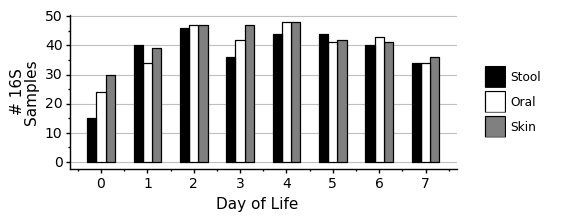

<ggplot: (8736399293921)>

In [70]:
pn.options.figure_size = (5,2)

plot_dat = bac_md.copy()
plot_dat["sample_type"] = pd.Categorical(plot_dat.sample_type, categories=["Stool", "Oral","Skin"])

p = (pn.ggplot(data=plot_dat) +
    pn.geom_histogram( pn.aes(x="age", group="sample_type", fill="sample_type"),
                      stat="count", position=pn.position_dodge(),
                     color="black", width=.6) +
     pn.scale_fill_manual(values=["black","white","grey"]) +
     pn.labs(fill='', y="# 16S\nSamples", x="Day of Life") +
     pn.scale_y_continuous(breaks=[0,10,20,30,40,50]) +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7,8,9,10]) +
     #pn.geom_hline(pn.aes(y=3), color="red")+
     pn.theme_classic() +
     pn.theme(
     panel_grid_major_y = pn.element_line(color="grey", alpha=.5),
         axis_text = pn.element_text(color="black", size=10)
     )
    )
#p.save(root_dir + "intermediate_data/20200618_16S_samples_histogram.pdf", dpi=300)
p

In [163]:
bac_tile_plot_dat = bac_md.copy()
bac_tile_plot_dat = bac_tile_plot_dat.loc[:,["host_subject_id", "metadata_abx","age","sample_type","study_delivery_mode"]]


new_blanks = []
for host in set(bac_tile_plot_dat.host_subject_id):
    for sample_type in ["Stool","Oral","Skin"]:
        for day in [0,1,2,3,4,5,6,7]:
            if bac_tile_plot_dat.query('host_subject_id==@host & sample_type==@sample_type & age==@day').shape[0]<1:
                study= bac_tile_plot_dat.query('host_subject_id==@host').study_delivery_mode[0]
                new_blanks.append([host, "missing", day, sample_type, study])
new_blank_df = pd.DataFrame(new_blanks, columns=["host_subject_id", "metadata_abx","age","sample_type","study_delivery_mode"])

bac_tile_plot_dat = pd.concat([bac_tile_plot_dat, new_blank_df])

bac_tile_plot_dat["sample_type"] = pd.Categorical(bac_tile_plot_dat.sample_type, categories=["Stool", "Oral","Skin"]) 

abx_label_conversion={0:"Yes (No Abx)", 1:"Yes (Infant Abx+)", "missing":"No"}
bac_tile_plot_dat["abx_label"] = pd.Categorical([abx_label_conversion[x] for x in bac_tile_plot_dat.metadata_abx],
                                       categories=["Yes (No Abx)", "Yes (Infant Abx+)","No"])
bac_tile_plot_dat["study_delivery_mode"] = pd.Categorical(bac_tile_plot_dat.study_delivery_mode,
                                                         categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/16S_samples_tile.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/16S_samples_tile.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


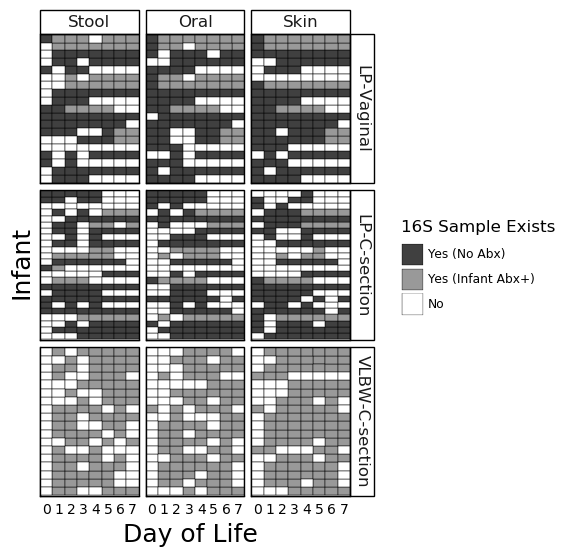

<ggplot: (8736392762621)>

In [164]:
pn.options.figure_size= (4,6)

p = (pn.ggplot(data=bac_tile_plot_dat) +
    pn.geom_tile( pn.aes(x="age", y="host_subject_id", fill="abx_label"), color="black", size=.2) +
     pn.scale_fill_manual(values=["#404040","#999999", "white"]) +
     pn.labs(fill='16S Sample Exists\n', y="Infant", x="Day of Life") +
     pn.facet_grid("study_delivery_mode~sample_type", scales="free") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7], expand=[0,0]) +
     #pn.geom_hline(pn.aes(y=3), color="red")+
     pn.theme_classic() +
     pn.theme(
         axis_text_x = pn.element_text(color="black", size=10),
         axis_text_y = pn.element_blank(),
         axis_title = pn.element_text(size=18),
         panel_border = pn.element_rect(color="black"),
         strip_text = pn.element_text(size=12),
         legend_title=pn.element_text(size=12),
         axis_ticks = pn.element_blank()
         
     )
    )
p.save(root_dir + "results/figures/svg/16S_samples_tile.svg", dpi=300)
p.save(root_dir + "results/figures/16S_samples_tile.pdf", dpi=300)
p

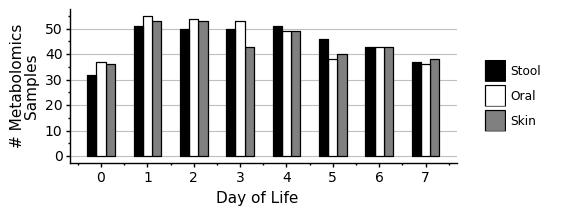

<ggplot: (-9223363270829198981)>

In [43]:
pn.options.figure_size = (5,2)

plot_dat = met_md.copy()
plot_dat["sample_type"] = pd.Categorical(plot_dat.sample_type, categories=["Stool", "Oral","Skin"])

p = (pn.ggplot(data=plot_dat) +
    pn.geom_histogram( pn.aes(x="age", group="sample_type", fill="sample_type"),
                      stat="count", position=pn.position_dodge(),
                     color="black", width=.6) +
     pn.scale_fill_manual(values=["black","white","grey"]) +
     pn.labs(fill='', y="# Metabolomics\nSamples", x="Day of Life") +
     pn.scale_y_continuous(breaks=[0,10,20,30,40,50]) +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7,8,9,10]) +
     pn.theme_classic() +
     pn.theme(
     panel_grid_major_y = pn.element_line(color="grey", alpha=.5),
         axis_text = pn.element_text(color="black", size=10)
     )
    )

#p.save(root_dir + "intermediate_data/20200618_metabolomics_samples_histogram.pdf", dpi=300)
p

In [165]:
met_tile_plot_dat = met_md.copy()
met_tile_plot_dat = met_tile_plot_dat.loc[:,["host_subject_id", "metadata_abx","age","sample_type","study_delivery_mode"]]


new_blanks = []
for host in set(met_tile_plot_dat.host_subject_id):
    for sample_type in ["Stool","Oral","Skin"]:
        for day in [0,1,2,3,4,5,6,7]:
            if met_tile_plot_dat.query('host_subject_id==@host & sample_type==@sample_type & age==@day').shape[0]<1:
                study= met_tile_plot_dat.query('host_subject_id==@host').study_delivery_mode[0]
                new_blanks.append([host, "missing", day, sample_type, study])
new_blank_df = pd.DataFrame(new_blanks, columns=["host_subject_id", "metadata_abx","age","sample_type","study_delivery_mode"])

met_tile_plot_dat = pd.concat([met_tile_plot_dat, new_blank_df])

met_tile_plot_dat["sample_type"] = pd.Categorical(met_tile_plot_dat.sample_type, categories=["Stool", "Oral","Skin"]) 

abx_label_conversion={0:"Yes (No Abx)", 1:"Yes (Infant Abx+)", "missing":"No"}
met_tile_plot_dat["abx_label"] = pd.Categorical([abx_label_conversion[x] for x in met_tile_plot_dat.metadata_abx],
                                       categories=["Yes (No Abx)", "Yes (Infant Abx+)","No"])
met_tile_plot_dat["study_delivery_mode"] = pd.Categorical(met_tile_plot_dat.study_delivery_mode,
                                                         categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/met_samples_tile.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 7 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/met_samples_tile.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


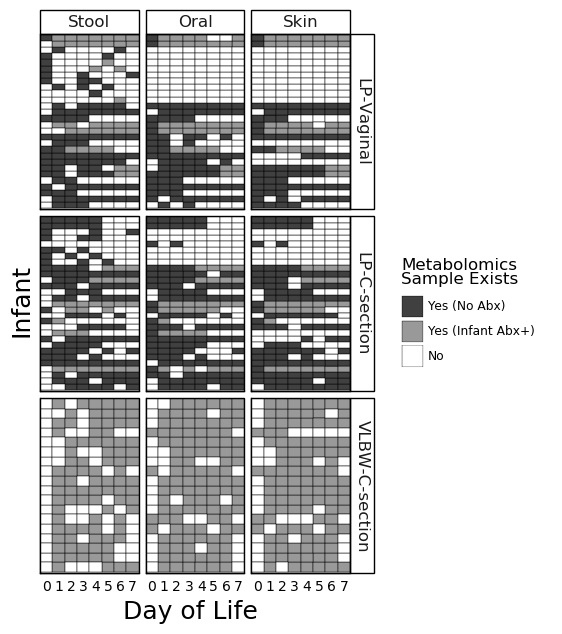

<ggplot: (8736392874013)>

In [166]:
pn.options.figure_size= (4,7)

p = (pn.ggplot(data=met_tile_plot_dat) +
    pn.geom_tile( pn.aes(x="age", y="host_subject_id", fill="abx_label"), color="black", size=.2) +
     pn.scale_fill_manual(values=["#404040","#999999", "white"]) +
     pn.labs(fill='Metabolomics\nSample Exists\n\n', y="Infant", x="Day of Life") +
     pn.facet_grid("study_delivery_mode~sample_type", scales="free") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7], expand=[0,0]) +
     #pn.geom_hline(pn.aes(y=3), color="red")+
     pn.theme_classic() +
     pn.theme(
         axis_text_x = pn.element_text(color="black", size=10),
         axis_text_y = pn.element_blank(),
         axis_title = pn.element_text(size=18),
         panel_border = pn.element_rect(color="black"),
         strip_text = pn.element_text(size=12),
         legend_title=pn.element_text(size=12),
         axis_ticks = pn.element_blank()
         
     )
    )
p.save(root_dir + "results/figures/svg/met_samples_tile.svg", dpi=300)
p.save(root_dir + "results/figures/met_samples_tile.pdf", dpi=300)
p

Merged 16S and bac tile

In [19]:
bac_samples = set(bac_md.index)
met_samples = set(met_md.index)
def sample_data(sample_id):
    if sample_id in bac_samples and sample_id in met_samples:
        return("16S and Metabolomics")
    elif sample_id in bac_samples:
        return("16S only")
    elif sample_id in met_samples:
         return("Metabolmics only")
    else:
        return("No data")
    
merged_md = pd.concat([bac_md, met_md])\
    .reset_index()\
    .drop_duplicates("sample_name")\
    .set_index("sample_name")
merged_md["data_types"] = [sample_data(x) for x in merged_md.index]

merged_tile_plot_dat = merged_md.copy()
merged_tile_plot_dat = merged_tile_plot_dat.loc[:,["host_subject_id", "metadata_abx","age","sample_type","study_delivery_mode","data_types"]]


new_blanks = []
for host in set(merged_tile_plot_dat.host_subject_id):
    for sample_type in ["Stool","Oral","Skin"]:
        for day in [0,1,2,3,4,5,6,7]:
            if merged_tile_plot_dat.query('host_subject_id==@host & sample_type==@sample_type & age==@day').shape[0]<1:
                study= merged_tile_plot_dat.query('host_subject_id==@host').study_delivery_mode[0]
                new_blanks.append([host, "missing", day, sample_type, study,"No data"])
new_blank_df = pd.DataFrame(new_blanks, columns=["host_subject_id", "metadata_abx","age","sample_type","study_delivery_mode","data_types"])

merged_tile_plot_dat = pd.concat([merged_tile_plot_dat, new_blank_df])

merged_tile_plot_dat["sample_type"] = pd.Categorical(merged_tile_plot_dat.sample_type, categories=["Stool", "Oral","Skin"]) 
merged_tile_plot_dat["study_delivery_mode"] = pd.Categorical(merged_tile_plot_dat.study_delivery_mode,
                                                         categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])

In [20]:
merged_tile_plot_dat['temp'] = merged_tile_plot_dat.data_types.replace({"16S and Metabolomics":1,
                                                                       "16S only":2,
                                                                       "Metabolmics only":3,
                                                                       "No data":4})
host_order = merged_tile_plot_dat.groupby('host_subject_id')\
    .agg({"temp":"sum"})\
    .sort_values(by="temp",ascending=False)\
    .index
merged_tile_plot_dat["host_subject_id"] = pd.Categorical(merged_tile_plot_dat["host_subject_id"],
                                                        categories=host_order)

In [17]:
import plotnine as pn

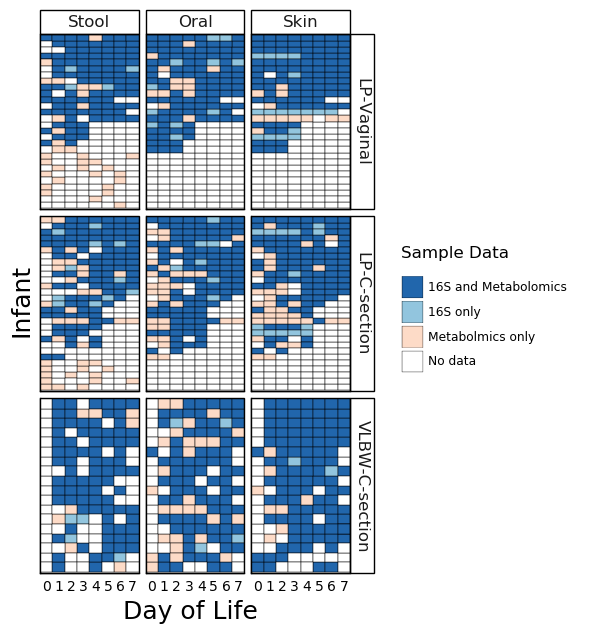

<ggplot: (8782120154888)>

In [36]:
pn.options.figure_size= (4,7)
colors=['#377eb8',  '#4daf4a','#ff7f00',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
colors= ["#2166ac","#92c5de","#fddbc7","white"]
p = (pn.ggplot(data=merged_tile_plot_dat) +
    pn.geom_tile( pn.aes(x="age", y="host_subject_id", fill="data_types"), color="black", size=.2) +
     #pn.scale_fill_manual(values=["#808080","#ef8a62","#67a9cf", "white"]) +
     pn.labs(fill='Sample Data\n\n', y="Infant", x="Day of Life") +
     pn.facet_grid("study_delivery_mode~sample_type", scales="free") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7], expand=[0,0]) +
     pn.scale_fill_manual(colors) +
     #pn.geom_hline(pn.aes(y=3), color="red")+
     pn.theme_classic() +
     pn.theme(
         axis_text_x = pn.element_text(color="black", size=10),
         axis_text_y = pn.element_blank(),
         axis_title = pn.element_text(size=18),
         panel_border = pn.element_rect(color="black"),
         strip_text = pn.element_text(size=12),
         legend_title=pn.element_text(size=12),
         axis_ticks = pn.element_blank()
         
     )
    )
#p.save(root_dir + "results/figures/svg/data_presence_tile.svg", dpi=300)
#p.save(root_dir + "results/figures/data_presence_tile.pdf", dpi=300)
p

[28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1]

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/data_presence_tile1.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)


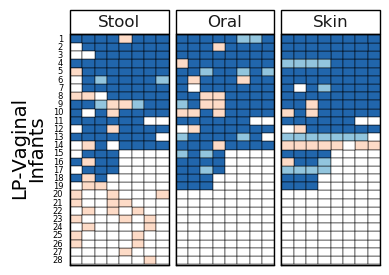

<ggplot: (8782119442152)>

In [53]:
pn.options.figure_size= (4,3)
colors= ["#2166ac","#92c5de","#fddbc7","white"]
p = (pn.ggplot(data=merged_tile_plot_dat.query('study_delivery_mode=="LP-Vaginal"')) +
    pn.geom_tile( pn.aes(x="age", y="host_subject_id", fill="data_types"), color="black", size=.2) +
     pn.scale_fill_manual(values=colors) +
     pn.labs(fill='Sample Data\n\n', y="LP-Vaginal\nInfants", x="") +
     pn.facet_grid(".~sample_type", scales="free") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7], expand=[0,0]) +
     pn.scale_y_discrete(labels=list(range(28,0,-1))) +
     #pn.geom_hline(pn.aes(y=3), color="red")+
     pn.theme_classic() +
     pn.guides(fill=None) + 
     pn.theme(
         axis_text_x = pn.element_blank(),
         axis_text_y = pn.element_text(size=6, color="black"),
         axis_title = pn.element_text(size=14),
         panel_border = pn.element_rect(color="black"),
         panel_background = pn.element_rect(color="black", size=1),
         strip_text = pn.element_text(size=12),
         legend_title=pn.element_text(size=12),
         axis_ticks = pn.element_blank()
         
     )
    )
p.save(root_dir + "results/figures/svg/data_presence_tile1.svg", dpi=300)
p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/data_presence_tile2.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)


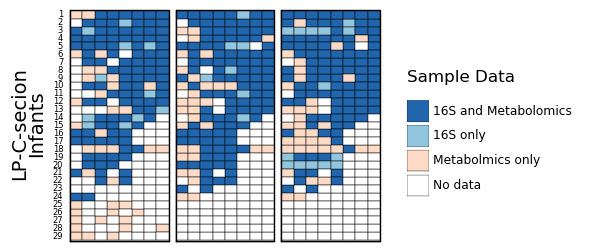

<ggplot: (-9223363254734025286)>

In [60]:
pn.options.figure_size= (4,3)
colors= ["#2166ac","#92c5de","#fddbc7","white"]
p = (pn.ggplot(data=merged_tile_plot_dat.query('study_delivery_mode=="LP-C-section"')) +
    pn.geom_tile( pn.aes(x="age", y="host_subject_id", fill="data_types"), color="black", size=.2) +
     pn.scale_fill_manual(values=colors) +
     pn.labs(fill='Sample Data\n\n', y="LP-C-secion\nInfants", x="") +
     pn.facet_grid(".~sample_type", scales="free") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7], expand=[0,0]) +
     pn.scale_y_discrete(labels=list(range(29,0,-1))) +
     #pn.geom_hline(pn.aes(y=3), color="red")+
     pn.theme_classic() +
     pn.theme(
         axis_text_x = pn.element_blank(),
         axis_text_y = pn.element_text(size=6, color="black"),
         axis_title = pn.element_text(size=14),
         strip_text = pn.element_blank(),
         strip_background = pn.element_blank(),
         panel_background = pn.element_rect(color="black", size=1),
         legend_title=pn.element_text(size=12),
         axis_ticks = pn.element_blank()
         
     )
    )
p.save(root_dir + "results/figures/svg/data_presence_tile2.svg", dpi=300)
p

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/data_presence_tile3.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)


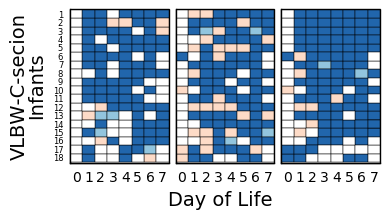

<ggplot: (8782120619759)>

In [61]:
pn.options.figure_size= (4,2)
colors= ["#2166ac","#92c5de","#fddbc7","white"]
p = (pn.ggplot(data=merged_tile_plot_dat.query('study_delivery_mode=="VLBW-C-section"')) +
    pn.geom_tile( pn.aes(x="age", y="host_subject_id", fill="data_types"), color="black", size=.2) +
     pn.scale_fill_manual(values=colors) +
     pn.labs(fill='Sample Data\n\n', y="VLBW-C-secion\nInfants", x="Day of Life") +
     pn.facet_grid(".~sample_type", scales="free") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7], expand=[0,0]) +
    pn.scale_y_discrete(labels=list(range(18,0,-1))) +
     pn.guides(fill=None) + 
     pn.theme_classic() +
     pn.theme(
         axis_text_x = pn.element_text(color="black", size=10),
         axis_text_y = pn.element_text(size=6, color="black"),
         axis_title = pn.element_text(size=14),
         strip_text = pn.element_blank(),
         panel_background = pn.element_rect(color="black", size=1),
         strip_background = pn.element_blank(),
         legend_title=pn.element_text(size=12),
         axis_ticks = pn.element_blank()
         
     )
    )
p.save(root_dir + "results/figures/svg/data_presence_tile3.svg", dpi=300)
p

# Antibiotics figure

In [145]:
abx_md = met_md.copy()
def abx_agreement(row):
    if row.metadata_abx and row.metabolomics_abx:
        return("Agree")
    elif row.metadata_abx and not row.metabolomics_abx:
        return("Metadata only")
    elif row.metabolomics_abx and not row.metadata_abx:
        return("Metabolomics only")
    elif not row.metadata_abx and not row.metabolomics_abx:
        return("Neither")
    
abx_md["abx_agreement"] = abx_md.apply(axis=1, func=abx_agreement)

In [147]:
abx_md.groupby("sample_type").abx_agreement.value_counts()

sample_type  abx_agreement    
Oral         Neither              142
             Metadata only        120
             Agree                 53
             Metabolomics only     50
Skin         Neither              173
             Metadata only        167
             Metabolomics only     11
             Agree                  4
Stool        Neither              158
             Metadata only         89
             Agree                 66
             Metabolomics only     47
Name: abx_agreement, dtype: int64

In [143]:
abx_md.loc[:,["metadata_abx","metabolomics_abx","abx_agreement"]]

,metadata_abx,metabolomics_abx,abx_agreement
sample_name,,,
11712.SUBJECT1.ORAL.1,0,1,Metabolomics only
11712.SUBJECT1.ORAL.2,0,0,Agree
11712.SUBJECT1.ORAL.3,0,0,Agree
11712.SUBJECT1.ORAL.4,0,0,Agree
11712.SUBJECT1.ORAL.6,0,0,Agree
...,...,...,...
11713.8.S.8C,1,0,Metadata only
11713.8.S.8D,1,0,Metadata only
11713.8.S.8E,1,0,Metadata only


In [133]:
!ls ../r

Doty_BileAcid_FeatureMetadata.txt
METABOLOMICS-SNETS-V2-ec46dc69-view_all_clusters_withID_beta-main.tsv
METABOLOMICS-SNETS-V2-ec46dc69-view_compound_occurrence-main.tsv
METABOLOMICS-SNETS-V2-f19d5ba5-view_all_clusters_withID_beta-main.tsv
METABOLOMICS-SNETS-V2-f19d5ba5-view_compound_occurrence-main.tsv
Stillwell_BileAcid_FeatureMetadata_06222020.txt


In [134]:
bac_md.metabolomics_abx

sample_name
11712.SUBJECT1.ORAL.2    0
11712.SUBJECT1.ORAL.3    0
11712.SUBJECT1.ORAL.4    0
11712.SUBJECT1.ORAL.5    0
11712.SUBJECT1.ORAL.6    0
                        ..
11713.8.S.8C             0
11713.8.S.8D             0
11713.8.S.8E             0
11713.8.S.8F             0
11713.8.S.8G             0
Name: metabolomics_abx, Length: 942, dtype: object

____

In [5]:
bac_md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", sep='\t')
met_md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_metabolomics_metadata.tsv", sep='\t')

NameError: name 'root_dir' is not defined

In [ ]:
bac_md.groupby("qiita_study_id").sample_type.value_counts()

In [ ]:
met_md.groupby("qiita_study_id").sample_type.value_counts()

In [7]:
bt_bac

NameError: name 'bt_bac' is not defined

# Decontamination

Format data

In [16]:
from biom.util import biom_open
def save_biom(biom_filename, biom_table,author='default'):
    with biom_open(biom_filename, 'w') as f:  
            biom_table.to_hdf5(f, author)
    print("Saved to " + biom_filename)

In [17]:

tax_qza =  q2.Artifact.load(root_dir + "intermediate_data/stody_seq_classification.qza")
tax_md_qza = q2.Metadata(pd.DataFrame(tax_qza.view(pd.Series)))
tax_df = tax_qza.view(pd.DataFrame)

In [53]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
#Import 16S
stillwell_bt = load_table(root_dir + "raw_data/56431_reference-hit.biom")
doty_bt = load_table(root_dir + "raw_data/56491_reference-hit.biom")
bac_bt = doty_bt.merge(stillwell_bt)
bac_qza = q2.Artifact.import_data('FeatureTable[Frequency]', bac_bt)
genus_qza = collapse(table=bac_qza, taxonomy=tax_qza, level=6).collapsed_table
genus_bt = genus_qza.view(Table)

#Get blank sample ids
qiita_doty=pd.read_csv(root_dir + 'metadata/raw/11712_20200406-134620.txt',sep='\t',index_col='sample_name',na_values='not applicable')
qiita_doty=qiita_doty.fillna("not applicable")
qiita_stillwell= pd.read_csv(root_dir + 'metadata/raw/11713_20190821-085347.txt',sep='\t',index_col='sample_name')
doty_blanks = set( qiita_doty.query('sample_type=="not applicable"').index )
stillwell_blanks = set( qiita_stillwell.query('sample_type=="not applicable"').index )
all_md_blanks = (doty_blanks | stillwell_blanks) & set(bac_bt.ids())


data_samples = set( bac_bt.ids() )
blank_md = pd.concat([qiita_doty.loc[:,["sample_type"]], qiita_stillwell.loc[:,["sample_type"]]])\
    .query('index in @data_samples')
blank_md["sample_type"] = ["TRUE" if x=="not applicable" else "FALSE" for x in blank_md.sample_type]

!mkdir -p $root_dir/intermediate_data/decontamination
save_biom(root_dir + "intermediate_data/decontamination/16S_table_with_blanks.biom",genus_bt)
blank_md.to_csv(root_dir + "intermediate_data/decontamination/blank_metadata.tsv", sep='\t')


Saved to /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/intermediate_data/decontamination/16S_table_with_blanks.biom


In [76]:
blank_bt = bac_bt.filter(all_md_blanks, inplace=False)
blank_df = bac_bt.to_dataframe()

In [87]:
sum_df = pd.DataFrame( blank_df.sum(axis=1), columns=["tot"] )\
            .merge(tax_df, right_index=True, left_index=True)

In [81]:
blank_freq_df =  pd.DataFrame( blank_df.apply(lambda x: x >0)\
                              .apply(axis=1, func=lambda row: sum(row)/len(row)), 
                              columns=["blank_freq"] )


In [83]:
blank_freq_df = blank_freq_df.merge(tax_df, right_index=True, left_index=True)

In [54]:
%%script bash

#Load environment
source ~/.bash_profile
conda activate qiime2-2020.2

#Set paths
root_dir=/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/
Rfile=$root_dir/sw_notebooks/utils/run_decontam.R
in_biom=$root_dir/intermediate_data/decontamination/16S_table_with_blanks.biom
in_metadata=$root_dir/intermediate_data/decontamination/blank_metadata.tsv

out_file=$root_dir/intermediate_data/decontamination/decontam_results.tsv
#Run Decontam prevalence
Rscript $Rfile $in_biom $in_metadata $out_file


Warning message:
In strsplit(conditionMessage(e), "\n") :
  input string 1 is invalid in this locale


In [20]:
#Load decontam results
dctm_results = pd.read_csv(root_dir + "/intermediate_data/decontamination/decontam_results.tsv", sep='\t', index_col=0)
contaminant_genera = dctm_results.query('contaminant==True').index

print(len(contaminant_genera))
print(contaminant_genera)


42
Index(['k__Bacteria;p__Acidobacteria;c__[Chloracidobacteria];o__11-24;f__;g__',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__;g__',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Glycomycetaceae;g__Haloglycomyces',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micromonosporaceae;__',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micromonosporaceae;g__Rugosimonospora',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Nocardioidaceae;g__Marmoricola',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Pseudonocardiaceae;g__Actinomycetospora',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Pseudonocardiaceae;g__Sciscionella',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Thermomonosporaceae;g__',
       'k__Bacteria;p__Actinobacteria;c__Thermol

In [21]:
dctm_results.loc[['Thermi' in x for x in dctm_results.index]]

,freq,prev,p.freq,p.prev,p,contaminant
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__[Thermicanaceae];g__Bacillus,1.323399e-05,14,NaN,0.834871,0.834871,False
k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__[Thermicanaceae];g__Thermicanus,2.442621e-05,8,NaN,0.293314,0.293314,False
k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinobacterium,6.293005e-07,2,NaN,0.572954,0.572954,False
k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus,1.153878e-03,437,NaN,0.997686,0.997686,False
k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__,4.797304e-07,1,NaN,NaN,NaN,False
k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__B-42,3.881669e-06,2,NaN,0.075808,0.075808,True
k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__Truepera,1.335103e-04,3,NaN,0.113499,0.113499,False
k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Meiothermus,9.850830e-04,376,NaN,0.998926,0.998926,False
k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus,3.608546e-03,971,NaN,0.999992,0.999992,False


In [63]:
blank_md.shape

(1794, 1)

In [65]:
dctm_results.query('contaminant==True').sort_values('prev', ascending=False).head(60)

,freq,prev,p.freq,p.prev,p,contaminant
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__;g__,1.586863e-04,86,NaN,0.048262,0.048262,True
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micromonosporaceae;__,7.004071e-05,43,NaN,0.070563,0.070563,True
k__Bacteria;p__Planctomycetes;c__Planctomycetia;o__Pirellulales;f__Pirellulaceae;g__Pirellula,3.420948e-05,31,NaN,0.052862,0.052862,True
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium,5.921304e-05,30,NaN,0.013916,0.013916,True
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Pseudonocardiaceae;g__Sciscionella,1.749325e-05,29,NaN,0.040936,0.040936,True
k__Bacteria;p__Actinobacteria;c__Thermoleophilia;o__Solirubrobacterales;f__Conexibacteraceae;g__,3.559005e-05,28,NaN,0.035661,0.035661,True
k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__Ellin515;g__,3.661171e-05,27,NaN,0.095581,0.095581,True
k__Bacteria;p__Firmicutes;c__Bacilli;o__Turicibacterales;f__Turicibacteraceae;g__Turicibacter,5.370086e-05,18,NaN,0.096424,0.096424,True
k__Bacteria;p__Deferribacteres;c__Deferribacteres;o__Deferribacterales;f__Deferribacteraceae;g__Mucispirillum,1.526762e-05,17,NaN,0.020722,0.020722,True
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Morganella,1.605824e-05,17,NaN,0.083673,0.083673,True


In [56]:
dctm_results.head()

,freq,prev,p.freq,p.prev,p,contaminant
Unassigned;__;__;__;__;__,7.184091e-08,1,NaN,NaN,NaN,False
k__Archaea;p__Crenarchaeota;c__MCG;o__;f__;g__,7.584797e-07,1,NaN,NaN,NaN,False
k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;__,8.596389e-06,2,NaN,0.572954,0.572954,False
k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__,1.988477e-06,3,NaN,0.605364,0.605364,False
k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__Cenarchaeum,1.092689e-06,3,NaN,0.605364,0.605364,False


In [44]:
bac_bt_filt1 = bac_bt.filter(contaminant_seqs, invert=True, axis="observation", inplace=False)

In [46]:
bac_bt

25438 x 1794 <class 'biom.table.Table'> with 96106 nonzero entries (0% dense)